In [1]:
#GhostInTheMachine

Environmental Setup  
python: 3.11.4  
numpy: 2.3.5  
matplotlib: 3.10.7  
sklearn: 1.4.2  
pandas: 2.3.3  
seaborn: 0.13.2  
pymc: 5.26.1  
arviz: 0.22.0  
g++ (Rev8, Built by MSYS2 project) 15.2.0  
pytensor 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Load the dataset
file_path = "/Users/Merlin/Desktop/Digisthra/IPL_Bowler_Detailed_Data.csv"
data = pd.read_csv(file_path)

In [6]:
data.head()

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,29504,12-Apr-23,Neutral,Powerplay,1,1,Bowler B,17.97,133.25,0,1
1,96402,30-Nov-23,Batting,Powerplay,5,1,Bowler A,20.51,119.98,0,0
2,27383,07-Nov-22,Neutral,Powerplay,1,5,Bowler B,30.05,124.73,2,0
3,99624,10-Apr-22,Batting,Powerplay,5,3,Bowler B,21.29,147.69,1,0
4,65569,23-Jun-23,Neutral,Powerplay,5,3,Bowler B,34.89,117.51,0,0


In [7]:
print("Shape of dataset:", data.shape)

Shape of dataset: (4800, 11)


In [8]:
# 1. Sort dataset
data = data.sort_values(by=["Match_ID", "Over", "Ball"]).reset_index(drop=True)
print("Data sorted by Match_ID, Over, Ball.")
data.head()

Data sorted by Match_ID, Over, Ball.


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1


In [9]:
data.duplicated().sum()

np.int64(0)

In [10]:
data[data.duplicated()]

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket


In [11]:
data.duplicated(subset=['Match_ID','Match_Date','Over', 'Ball','Bowler']).sum()

np.int64(432)

In [12]:
data[data.duplicated(subset=['Match_ID','Match_Date','Over', 'Ball','Bowler'],keep=False)]

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
12,11935,28-Jan-23,Batting,Death,17,1,Bowler B,26.18,145.06,6,0
13,11935,28-Jan-23,Batting,Death,17,1,Bowler B,33.65,148.68,4,0
14,11935,28-Jan-23,Batting,Death,17,2,Bowler B,48.59,122.68,6,0
15,11935,28-Jan-23,Batting,Death,17,2,Bowler B,40.02,117.55,6,0
16,11935,28-Jan-23,Batting,Death,17,3,Bowler B,37.21,126.98,4,0
...,...,...,...,...,...,...,...,...,...,...,...
4747,99317,12-Sep-22,Batting,Death,16,4,Bowler A,34.52,143.23,0,0
4748,99317,12-Sep-22,Batting,Death,16,5,Bowler A,28.07,153.93,1,0
4749,99317,12-Sep-22,Batting,Death,16,5,Bowler A,41.56,163.81,0,0
4750,99317,12-Sep-22,Batting,Death,16,6,Bowler A,22.07,126.37,2,0


In [13]:
conflicts = (
    data.groupby(['Match_ID', 'Match_Date', 'Over', 'Ball', 'Bowler'])
      .filter(lambda g: g['Runs_Conceded'].nunique() > 1 
                       or g['Is_Wicket'].nunique() > 1)
)
conflicts.head()

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
12,11935,28-Jan-23,Batting,Death,17,1,Bowler B,26.18,145.06,6,0
13,11935,28-Jan-23,Batting,Death,17,1,Bowler B,33.65,148.68,4,0
16,11935,28-Jan-23,Batting,Death,17,3,Bowler B,37.21,126.98,4,0
17,11935,28-Jan-23,Batting,Death,17,3,Bowler B,29.46,134.73,0,0
18,11935,28-Jan-23,Batting,Death,17,4,Bowler B,19.15,157.13,1,0


In [14]:
conflicts.shape

(632, 11)

In [15]:
data_no_conflicts = data.merge(
    conflicts[['Match_ID','Match_Date','Over','Ball','Bowler']].drop_duplicates(),
    on=['Match_ID','Match_Date','Over','Ball','Bowler'],
    how='left',
    indicator=True
)

data_no_conflicts = data_no_conflicts[data_no_conflicts['_merge'] == 'left_only'].drop('_merge', axis=1)
data_no_conflicts.head()

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1


In [16]:
data_no_conflicts.shape

(4168, 11)

In [17]:
# 1. Save the original column order
orig_cols = data_no_conflicts.columns.tolist()

# 2. Build aggregation dictionary
agg_dict = {
    'Batter_Avg': 'mean',
    'Batter_SR': 'mean'
}
for col in data_no_conflicts.columns:
    if col not in ['Match_ID','Match_Date','Pitch_Type','Phase','Over','Ball','Bowler'] and col not in agg_dict:
        agg_dict[col] = 'first'
            

In [18]:
# 3. Aggregate to create df_clean
df = (
    data_no_conflicts
    .groupby(['Match_ID','Match_Date','Pitch_Type','Phase','Over','Ball','Bowler'], as_index=False)
    .agg(agg_dict)
)

In [19]:
# 4. Reorder df_clean columns to original order
df = df[orig_cols]#clean data

df.head(10)

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
0,11935,28-Jan-23,Batting,Death,17,2,Bowler B,44.305,120.115,6,0
1,11935,28-Jan-23,Batting,Death,17,6,Bowler B,35.395,151.010,1,0
2,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.460,131.680,0,0
3,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.410,138.410,3,0
4,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.800,107.220,0,0
5,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.310,136.440,0,0
6,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.520,105.850,0,1
7,11935,28-Jan-23,Batting,Powerplay,2,6,Bowler B,29.760,108.500,0,1
8,11935,28-Jan-23,Batting,Powerplay,6,1,Bowler B,27.910,137.660,2,0
9,11935,28-Jan-23,Batting,Powerplay,6,2,Bowler B,26.830,115.520,4,0


In [24]:
df.duplicated(subset=['Match_ID','Match_Date','Over', 'Ball','Bowler']).sum()

np.int64(0)

In [20]:
print("Shape of dataset:", df.shape)

Shape of dataset: (4052, 11)


In [21]:
print("Data Types:")
print(df.dtypes)

Data Types:
Match_ID           int64
Match_Date        object
Pitch_Type        object
Phase             object
Over               int64
Ball               int64
Bowler            object
Batter_Avg       float64
Batter_SR        float64
Runs_Conceded      int64
Is_Wicket          int64
dtype: object


In [22]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Match_ID         0
Match_Date       0
Pitch_Type       0
Phase            0
Over             0
Ball             0
Bowler           0
Batter_Avg       0
Batter_SR        0
Runs_Conceded    0
Is_Wicket        0
dtype: int64


In [25]:
for col in df.columns:
    print(f"{col} -> {df[col].nunique()} unique values")

Match_ID -> 200 unique values
Match_Date -> 172 unique values
Pitch_Type -> 3 unique values
Phase -> 2 unique values
Over -> 11 unique values
Ball -> 6 unique values
Bowler -> 2 unique values
Batter_Avg -> 2497 unique values
Batter_SR -> 3158 unique values
Runs_Conceded -> 6 unique values
Is_Wicket -> 2 unique values


In [26]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print("Unique Values:", df[col].unique())


Column: Match_ID
Unique Values: [11935 11943 11951 11982 12853 13271 13641 14311 14861 15313 15812 16473
 16523 16846 16910 17239 17491 18611 19223 19921 19963 20129 20304 20547
 22926 23186 23565 24645 24878 25078 25795 26066 26679 27349 27383 27857
 28058 28452 29504 30079 30193 30316 30637 31395 32097 32778 33401 33459
 33478 33641 34599 34644 35185 36649 36651 36709 36797 36872 37268 37798
 38688 38797 39350 39482 39545 39550 39738 40988 41422 42535 43149 43487
 43892 44020 44072 44207 44961 45687 45909 46289 46292 46593 47158 48165
 48196 49282 49321 49931 49994 50148 51568 52154 52244 52823 53168 53617
 53950 54941 55242 55406 55812 56040 56157 56433 58511 59047 59056 59240
 60341 60345 60629 60697 60710 61516 62269 63625 64380 64748 64856 65569
 66160 66233 66478 66700 67149 67290 67439 67541 68414 68914 69269 69821
 69902 70824 71331 71739 72912 73788 74325 74783 75875 76351 76553 77194
 77957 78619 79806 80393 80631 80792 81011 82131 82588 82799 83177 83932
 84264 84637 84727

In [27]:
print("\nSummary statistics:")
df.drop(columns=["Match_ID"]).describe()


Summary statistics:


,Over,Ball,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
count,4052.000000,4052.000000,4052.000000,4052.000000,4052.000000,4052.000000
mean,10.513574,3.498766,31.429093,139.909847,1.341560,0.068361
std,7.439516,1.707939,9.731857,20.094134,1.754726,0.252396
min,1.000000,1.000000,-1.570000,69.190000,0.000000,0.000000
25%,3.000000,2.000000,24.760000,125.960000,0.000000,0.000000
50%,6.000000,3.000000,31.070000,138.295000,1.000000,0.000000
75%,18.000000,5.000000,37.781250,152.857500,2.000000,0.000000
max,20.000000,6.000000,66.740000,208.920000,6.000000,1.000000


In [28]:
df[df["Batter_Avg"] <= 0]

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
1879,52244,08-Aug-23,Batting,Powerplay,6,6,Bowler A,-1.57,131.13,0,0


In [29]:
# 1. Convert the invalid negative value to NaN so it doesn't affect the calculation
df.loc[df['Batter_Avg'] < 0, 'Batter_Avg'] = np.nan

# 2. Calculate the mean of that specific over (grouping by context) and fill the NaN
group_cols = ['Match_ID', 'Match_Date', 'Pitch_Type', 'Phase', 'Over']

df['Batter_Avg'] = df['Batter_Avg'].fillna(
    df.groupby(group_cols)['Batter_Avg'].transform('mean')
)

In [30]:
(df["Batter_Avg"] <= 0).sum()

np.int64(0)

In [31]:
print("\nSummary statistics:")
df.drop(columns=["Match_ID"]).describe()


Summary statistics:


,Over,Ball,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket
count,4052.000000,4052.000000,4052.000000,4052.000000,4052.000000,4052.000000
mean,10.513574,3.498766,31.436162,139.909847,1.341560,0.068361
std,7.439516,1.707939,9.718275,20.094134,1.754726,0.252396
min,1.000000,1.000000,0.260000,69.190000,0.000000,0.000000
25%,3.000000,2.000000,24.767500,125.960000,0.000000,0.000000
50%,6.000000,3.000000,31.070000,138.295000,1.000000,0.000000
75%,18.000000,5.000000,37.781250,152.857500,2.000000,0.000000
max,20.000000,6.000000,66.740000,208.920000,6.000000,1.000000


In [32]:
print("Categorical Counts\n")
for col in ['Pitch_Type', 'Phase', 'Bowler', 'Is_Wicket']:
    print(df[col].value_counts(normalize=True))
    print("\n")

Categorical Counts

Pitch_Type
Batting    0.387463
Neutral    0.333909
Bowling    0.278628
Name: proportion, dtype: float64


Phase
Powerplay    0.51382
Death        0.48618
Name: proportion, dtype: float64


Bowler
Bowler A    0.509131
Bowler B    0.490869
Name: proportion, dtype: float64


Is_Wicket
0    0.931639
1    0.068361
Name: proportion, dtype: float64




Count Plots for Categorical Columns


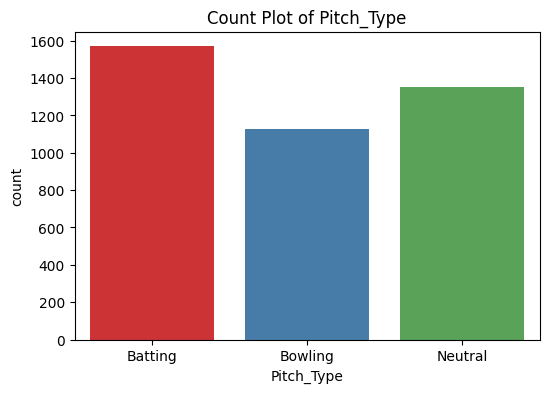

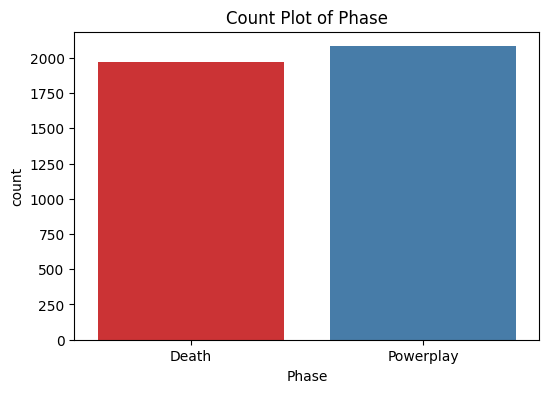

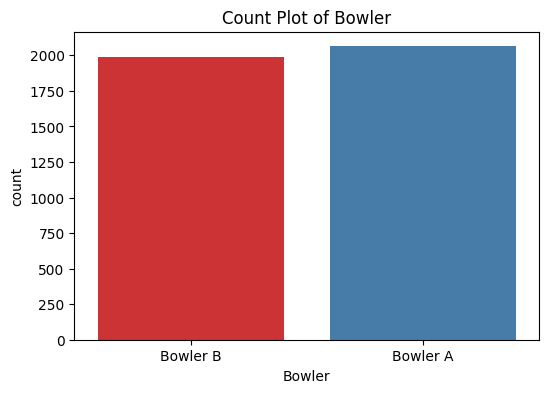

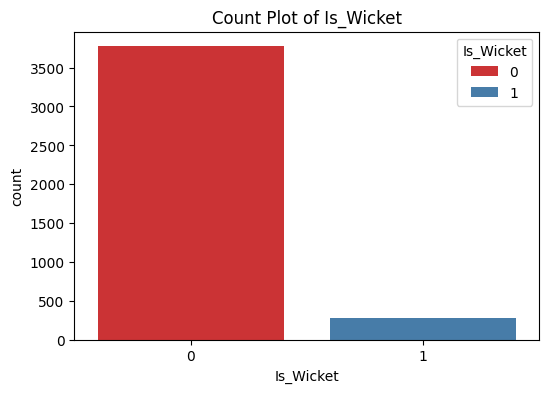

In [33]:
print("Count Plots for Categorical Columns")
categorical_cols = ['Pitch_Type', 'Phase', 'Bowler',"Is_Wicket"]

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue = col, palette='Set1')
    plt.title(f"Count Plot of {col}")
    plt.show()

Distribution Plots for Numeric Columns


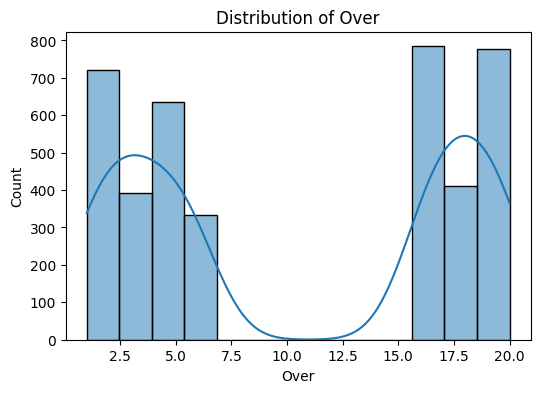

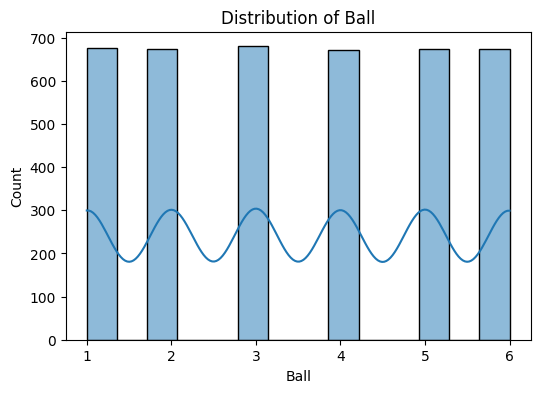

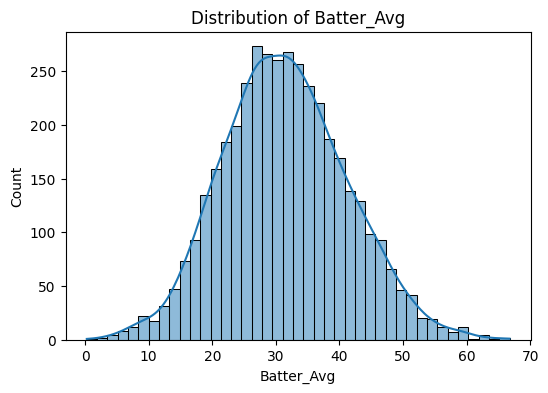

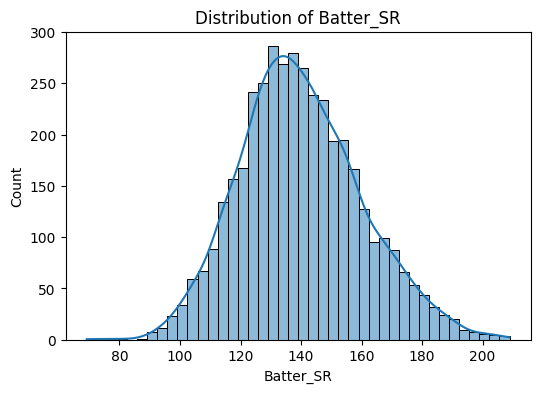

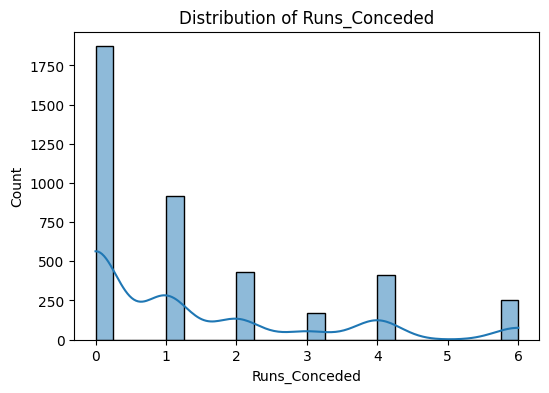

In [34]:
print("Distribution Plots for Numeric Columns")
numeric_cols = ['Over', 'Ball', 'Batter_Avg', 'Batter_SR', 'Runs_Conceded']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

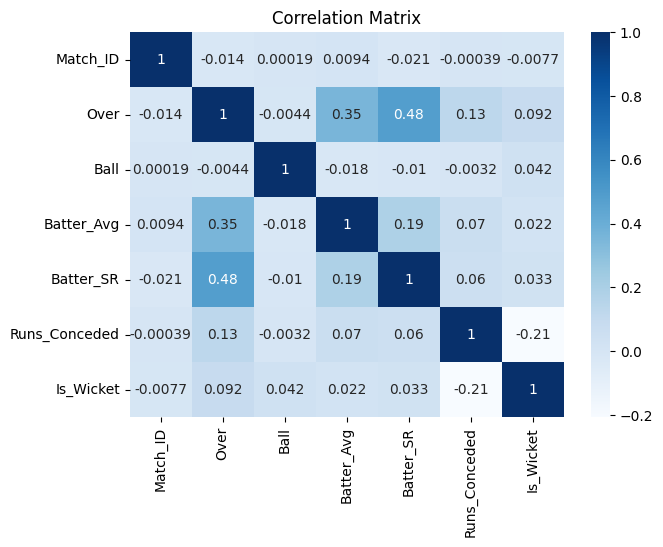

In [36]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

In [38]:
print("Baseline Bowler Comparison")
# Metrics calculation
bowler_stats = df.groupby('Bowler').agg(
    Balls_Bowled=('Ball', 'count'),
    Total_Runs=('Runs_Conceded', 'sum'),
    Total_Wickets=('Is_Wicket', 'sum'),
    Dot_Balls=('Runs_Conceded', lambda x: (x==0).sum())
)
# Derived metrics
bowler_stats['Economy_Rate'] = (bowler_stats['Total_Runs'] / bowler_stats['Balls_Bowled']) * 6
bowler_stats['Strike_Rate'] = bowler_stats['Balls_Bowled'] / bowler_stats['Total_Wickets']
bowler_stats['Dot_Ball_Percentage'] = (bowler_stats['Dot_Balls'] / bowler_stats['Balls_Bowled']) * 100

print(bowler_stats)

Baseline Bowler Comparison
          Balls_Bowled  Total_Runs  Total_Wickets  Dot_Balls  Economy_Rate  \
Bowler                                                                       
Bowler A          2063        2482             89        956      7.218614   
Bowler B          1989        2954            188        916      8.911011   

          Strike_Rate  Dot_Ball_Percentage  
Bowler                                      
Bowler A    23.179775            46.340281  
Bowler B    10.579787            46.053293  


In [39]:
print("Dot Ball Analysis")
df['Is_Dot'] = (df['Runs_Conceded'] == 0).astype(int)

print("\nDot ball rate:")
print(df['Is_Dot'].mean())

print("\nDot ball rate by bowler:")
print(df.groupby('Bowler')['Is_Dot'].mean())

print("\nDot ball Rate by Phase:")
print(df.groupby('Phase')['Is_Dot'].mean())

Dot Ball Analysis

Dot ball rate:
0.46199407699901285

Dot ball rate by bowler:
Bowler
Bowler A    0.463403
Bowler B    0.460533
Name: Is_Dot, dtype: float64

Dot ball Rate by Phase:
Phase
Death        0.380203
Powerplay    0.539385
Name: Is_Dot, dtype: float64


In [40]:
print("Phase-wise Performance")
phase_stats_dot = df.groupby(['Bowler', 'Phase']).agg(
    Economy_Rate=('Runs_Conceded', lambda x: (x.sum() / x.count()) * 6),
    Dot_Count=('Is_Dot', 'sum')
).reset_index()
print(phase_stats_dot)

Phase-wise Performance
     Bowler      Phase  Economy_Rate  Dot_Count
0  Bowler A      Death      7.966337        387
1  Bowler A  Powerplay      6.501425        569
2  Bowler B      Death     11.006250        362
3  Bowler B  Powerplay      6.956268        554


In [41]:
print("Wicket Rates Overview")
print("\nOverall Wicket Rate:", df['Is_Wicket'].mean())
print("\nWicket Rate by Bowler:")
print(df.groupby('Bowler')['Is_Wicket'].mean())
print("\nWicket Rate by Phase:")
print(df.groupby('Phase')['Is_Wicket'].mean())

Wicket Rates Overview

Overall Wicket Rate: 0.06836130306021718

Wicket Rate by Bowler:
Bowler
Bowler A    0.043141
Bowler B    0.094520
Name: Is_Wicket, dtype: float64

Wicket Rate by Phase:
Phase
Death        0.092386
Powerplay    0.045629
Name: Is_Wicket, dtype: float64


In [42]:
print("Phase-wise Performance")
phase_stats = df.groupby(['Bowler', 'Phase']).agg(
    #Economy_Rate=('Runs_Conceded', lambda x: (x.sum() / x.count()) * 6),
    Wicket_Count=('Is_Wicket', 'sum')
).reset_index()
print(phase_stats)

Phase-wise Performance
     Bowler      Phase  Wicket_Count
0  Bowler A      Death            37
1  Bowler A  Powerplay            52
2  Bowler B      Death           145
3  Bowler B  Powerplay            43


Runs and Wicket Patterns


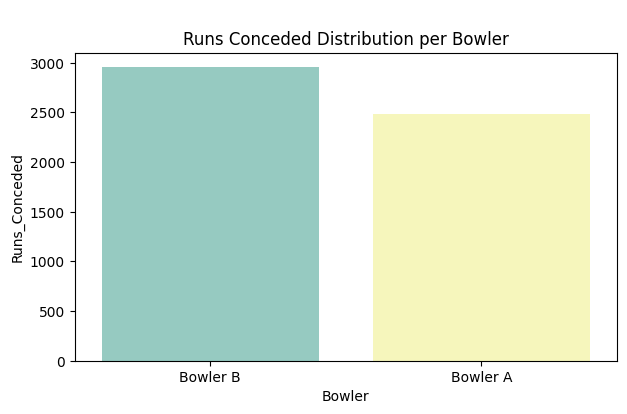

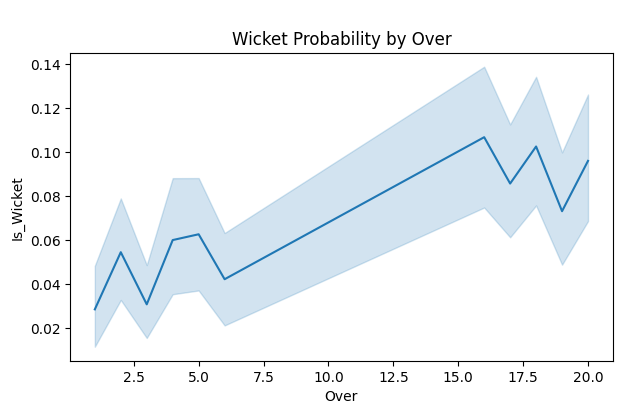

In [43]:
print("Runs and Wicket Patterns")

# Runs conceded per bowler
plt.figure(figsize=(7,4))
sns.barplot(data=df, x='Bowler', y='Runs_Conceded', estimator='sum',hue="Bowler",errorbar=None,palette='Set3')
plt.title("\nRuns Conceded Distribution per Bowler")
plt.show()

# Wickets per over
plt.figure(figsize=(7,4))
sns.lineplot(data=df, x='Over', y='Is_Wicket', estimator='mean')
plt.title("\nWicket Probability by Over")
plt.show()

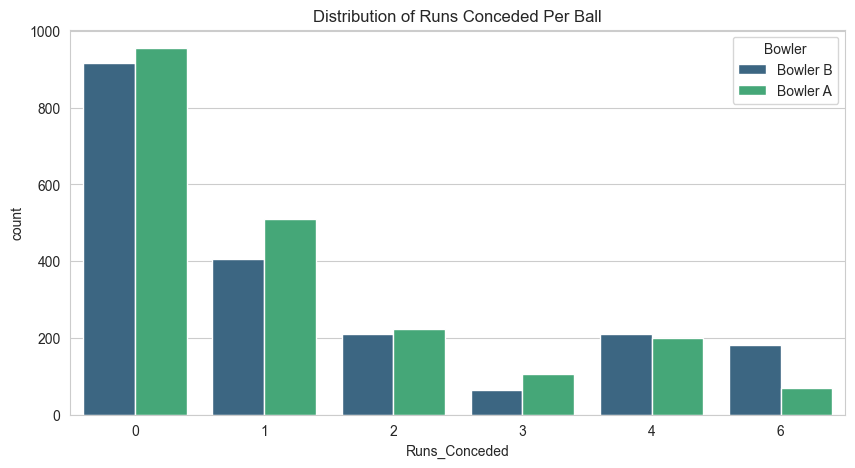

In [44]:
sns.set_style("whitegrid")

# Plot: Distribution of Runs Conceded (Economy)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Runs_Conceded', hue='Bowler', palette='viridis')
plt.title('Distribution of Runs Conceded Per Ball')
plt.show()

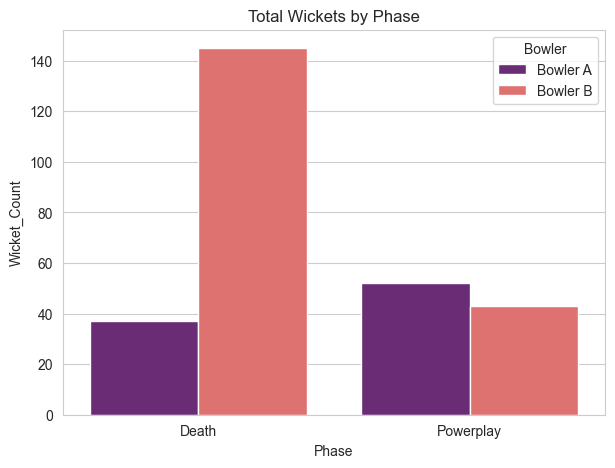

In [47]:
# Plot: Wickets by Phase
plt.figure(figsize=(7, 5))
sns.barplot(data=phase_stats, x='Phase', y='Wicket_Count', hue='Bowler', palette='magma')
plt.title('Total Wickets by Phase')
plt.show()

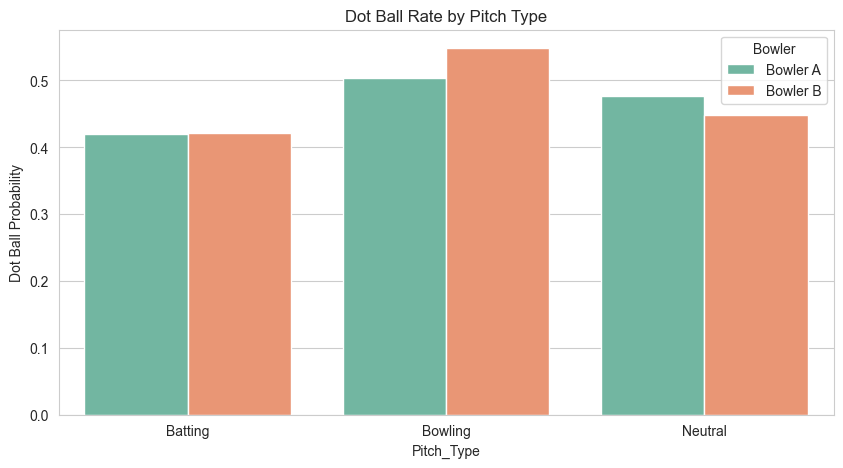

In [48]:
# Plot: Dot Ball Percentage by Pitch Type
dot_ball_pitch = df.groupby(['Bowler', 'Pitch_Type'])['Runs_Conceded'].apply(lambda x: (x==0).mean()).reset_index(name='Dot_Ball_Rate')
plt.figure(figsize=(10, 5))
sns.barplot(data=dot_ball_pitch, x='Pitch_Type', y='Dot_Ball_Rate', hue='Bowler', palette='Set2')
plt.title('Dot Ball Rate by Pitch Type')
plt.ylabel('Dot Ball Probability')
plt.show()

In [50]:
# Calculate the average batter quality faced by each bowler
batter_quality_stats = df.groupby('Bowler')['Batter_Avg'].describe()
print("Batter Quality Stats:")
print(batter_quality_stats[['mean', 'std', 'min', 'max']])

# Also check specifically in Death Overs (since that's where the model runs)
death_quality = df[df['Phase'] == 'Death'].groupby('Bowler')['Batter_Avg'].describe()
print("\nBatter Quality in Death Overs:")
print(death_quality[['mean', 'std', 'min', 'max']])

Batter Quality Stats:
               mean       std   min    max
Bowler                                    
Bowler A  31.259909  9.671666  0.26  66.74
Bowler B  31.618972  9.765455  2.87  66.46

Batter Quality in Death Overs:
               mean        std   min    max
Bowler                                     
Bowler A  34.733460   9.920606  6.16  66.74
Bowler B  35.401083  10.008375  3.00  66.46


In [51]:
# PHASE 1: THE "MENTAL PROXY" (FEATURE ENGINEERING)

In [52]:
# 1. Sort dataset
df = df.sort_values(by=["Match_ID", "Over", "Ball"]).reset_index(drop=True)
print("Data sorted by Match_ID, Over, Ball.")
df.head()

Data sorted by Match_ID, Over, Ball.


,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket,Is_Dot
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0,1
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0,0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0,1
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0,1
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1,1


In [53]:
# 2. Create Dot Ball Indicator
df["Is_Dot"] = (df["Runs_Conceded"] == 0).astype(int)
print("Created Is_Dot column.")
#df["Is_Dot"]

Created Is_Dot column.


In [55]:
# 3. Grouped Shift: Get previous ball's runs, over, ball
df["prev_runs"] = df.groupby(["Match_ID", "Over"])["Runs_Conceded"].shift(1)
df["prev_ball"] = df.groupby(["Match_ID", "Over"])["Ball"].shift(1)
df.head()

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket,Is_Dot,prev_runs,prev_ball
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0,1,NaN,NaN
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0,0,0.0,1.0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0,1,3.0,2.0
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0,1,0.0,3.0
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1,1,0.0,4.0


In [56]:
# Fill NaNs (first ball of every over)
df["prev_runs"] = df["prev_runs"].fillna(-1)  # -1 means "no previous dot"
df["prev_ball"] = df["prev_ball"].fillna(-1)
df.head(50)
print("Grouped shift applied. Previous ball info collected.")

Grouped shift applied. Previous ball info collected.


In [57]:
# 4. Pressure is only in DEATH overs
df["is_death_over"] = df["Over"].isin([16, 17, 18, 19, 20]).astype(int)
df.head()

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket,Is_Dot,prev_runs,prev_ball,is_death_over
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0,1,-1.0,-1.0,0
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0,0,0.0,1.0,0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0,1,3.0,2.0,0
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0,1,0.0,3.0,0
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1,1,0.0,4.0,0


In [58]:
# 5. Pressure logic:
# Apply pressure only if ALL conditions are TRUE:
#   - Current ball is death over
#   - Previous ball was a dot (prev_runs == 0)
#   - Previous ball is exactly Ball - 1
#   - Previous ball is in the SAME over (enforced via grouped shift)
# ----------------------------------------------------------
df["pressure_applied"] = (
    (df["is_death_over"] == 1) &
    (df["prev_runs"] == 0) &
    (df["prev_ball"] == df["Ball"] - 1)
).astype(int)

df.head()
#print("Pressure_Applied column successfully created!")

,Match_ID,Match_Date,Pitch_Type,Phase,Over,Ball,Bowler,Batter_Avg,Batter_SR,Runs_Conceded,Is_Wicket,Is_Dot,prev_runs,prev_ball,is_death_over,pressure_applied
0,11935,28-Jan-23,Batting,Powerplay,2,1,Bowler B,33.46,131.68,0,0,1,-1.0,-1.0,0,0
1,11935,28-Jan-23,Batting,Powerplay,2,2,Bowler B,41.41,138.41,3,0,0,0.0,1.0,0,0
2,11935,28-Jan-23,Batting,Powerplay,2,3,Bowler B,26.80,107.22,0,0,1,3.0,2.0,0,0
3,11935,28-Jan-23,Batting,Powerplay,2,4,Bowler B,9.31,136.44,0,0,1,0.0,3.0,0,0
4,11935,28-Jan-23,Batting,Powerplay,2,5,Bowler B,19.52,105.85,0,1,1,0.0,4.0,0,0


In [59]:
#Count pressure events
print("Total pressure_applied events:", df["pressure_applied"].sum())

#Pressure should NEVER be applied on Ball=1
ball1_pressure = df[df["Ball"] == 1]["pressure_applied"].sum()
print("Pressure applied on Ball=1:", ball1_pressure, "(must be 0)")

#Pressure occurs in overs 16–20
print("Unique overs where pressure was applied:",
      df[df["pressure_applied"] == 1]["Over"].unique())

#Show sample rows with pressure
print("\nSample rows with Pressure Applied:")
print(df[df["pressure_applied"] == 1].head())

Total pressure_applied events: 618
Pressure applied on Ball=1: 0 (must be 0)
Unique overs where pressure was applied: [18 19 17 20 16]

Sample rows with Pressure Applied:
    Match_ID Match_Date Pitch_Type  Phase  Over  Ball    Bowler  Batter_Avg  \
31     11943  15-Mar-22    Batting  Death    18     6  Bowler B       29.56   
36     11943  15-Mar-22    Batting  Death    19     5  Bowler B       35.70   
37     11943  15-Mar-22    Batting  Death    19     6  Bowler B       33.59   
51     11951  17-Jan-22    Bowling  Death    17     2  Bowler A       33.00   
52     11951  17-Jan-22    Bowling  Death    17     3  Bowler A       50.10   

    Batter_SR  Runs_Conceded  Is_Wicket  Is_Dot  prev_runs  prev_ball  \
31     166.52              4          0       0        0.0        5.0   
36     173.50              0          1       1        0.0        4.0   
37     132.87              1          0       0        0.0        5.0   
51     154.99              0          0       1        0.0    

In [60]:
print("PROBABILITY CALCULATIONS")

#Filter only balls where pressure was applied
pressure_df = df[df["pressure_applied"] == 1]

#Raw probability of wicket after pressure (overall)
overall_prob = pressure_df["Is_Wicket"].mean()
print("Overall probability of wicket AFTER pressure:", overall_prob)

#Probability of wicket after pressure PER bowler
prob_by_bowler = pressure_df.groupby("Bowler")["Is_Wicket"].mean()
print("\nProbability of wicket AFTER pressure (by bowler):")
print(prob_by_bowler)

#Probability of wicket with NO pressure (baseline comparison)
no_pressure_df = df[df["pressure_applied"] == 0]
baseline_prob = no_pressure_df["Is_Wicket"].mean()
print("\nBaseline probability of wicket WITHOUT pressure:", baseline_prob)

#Baseline per bowler
baseline_by_bowler = no_pressure_df.groupby("Bowler")["Is_Wicket"].mean()
print("\nBaseline probability WITHOUT pressure (by bowler):")
print(baseline_by_bowler)

PROBABILITY CALCULATIONS
Overall probability of wicket AFTER pressure: 0.2022653721682848

Probability of wicket AFTER pressure (by bowler):
Bowler
Bowler A    0.021875
Bowler B    0.395973
Name: Is_Wicket, dtype: float64

Baseline probability of wicket WITHOUT pressure: 0.0442632498543972

Baseline probability WITHOUT pressure (by bowler):
Bowler
Bowler A    0.047045
Bowler B    0.041396
Name: Is_Wicket, dtype: float64


In [94]:
#counts
wicket_check = df[df["pressure_applied"] == 1]

count_pressure = len(wicket_check)
count_wickets_after_pressure = wicket_check["Is_Wicket"].sum()
prob = wicket_check["Is_Wicket"].mean()

print("Total pressure situations:", count_pressure)
print("Wickets immediately after pressure:", count_wickets_after_pressure)

Total pressure situations: 618
Wickets immediately after pressure: 125


In [62]:
#Print count per bowler
pressure_counts = df[df["pressure_applied"]==1].groupby("Bowler")["pressure_applied"].count()
print("Pressure event counts (per bowler):")
print(pressure_counts)

Pressure event counts (per bowler):
Bowler
Bowler A    320
Bowler B    298
Name: pressure_applied, dtype: int64


In [63]:
#Count: How many wickets happened AFTER pressure was applied (per bowler)
wicket_after_pressure = df[
    (df["pressure_applied"] == 1) &
    (df["Is_Wicket"] == 1)
].groupby("Bowler")["Is_Wicket"].count()

print("Wickets after pressure (per bowler):")
print(wicket_after_pressure)

Wickets after pressure (per bowler):
Bowler
Bowler A      7
Bowler B    118
Name: Is_Wicket, dtype: int64


In [89]:

# Total wickets per bowler
total_wickets = df.groupby("Bowler")["Is_Wicket"].sum()
print(total_wickets)


Bowler
Bowler A     89
Bowler B    188
Name: Is_Wicket, dtype: int64


In [90]:
# Percentage of wickets that occurred AFTER pressure

# Filter death overs (16-20)
death_overs = df[df["Phase"] == "Death"]

# Total wickets per bowler
total_wickets = death_overs.groupby("Bowler")["Is_Wicket"].sum()

# Total balls bowled per bowler in death overs
total_balls = death_overs.groupby("Bowler")["Ball"].count()

# Calculate % of wickets after pressure
percentage_after_pressure = (wicket_after_pressure / total_wickets * 100).fillna(0)

# Combine results nicely
pressure_wicket_percentage = pd.DataFrame({
    "Total Balls": total_balls,
    "Total Wickets": total_wickets,
    "Wickets After Pressure": wicket_after_pressure,
    "% Wickets After Pressure": percentage_after_pressure.round(2)
})

print("Bowler stats in Death Overs:")
print(pressure_wicket_percentage)


Bowler stats in Death Overs:
          Total Balls  Total Wickets  Wickets After Pressure  \
Bowler                                                         
Bowler A         1010             37                       7   
Bowler B          960            145                     118   

          % Wickets After Pressure  
Bowler                              
Bowler A                     18.92  
Bowler B                     81.38  


In [46]:
# PHASE 2 – BAYESIAN MODEL

In [64]:
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [65]:
# Make a copy — keep only death overs dataset
df_model = df[df["is_death_over"] == 1].copy()
print("Rows used for modeling:", len(df_model))

Rows used for modeling: 1970


In [66]:
# 1. ENCODING CATEGORICAL VARIABLES

# Bowler encoding → 0 or 1
bowler_map = {name: i for i, name in enumerate(df_model["Bowler"].unique())}
df_model["bowler_idx"] = df_model["Bowler"].map(bowler_map).astype(int)

# Pitch encoding → 0, 1, 2...
pitch_map = {name: i for i, name in enumerate(df_model["Pitch_Type"].unique())}
df_model["pitch_idx"] = df_model["Pitch_Type"].map(pitch_map).astype(int)
n_pitches = df_model["pitch_idx"].nunique()

In [67]:
# 2. STANDARDIZE BATTER AVG

scaler = StandardScaler()
df_model["batter_avg_z"] = scaler.fit_transform(
    df_model[["Batter_Avg"]].fillna(df_model["Batter_Avg"].mean())
)

In [68]:
# 3. PREPARE MODEL INPUTS

bowler_idx = df_model["bowler_idx"].values
pitch_idx = df_model["pitch_idx"].values
pressure = df_model["pressure_applied"].values
batter_avg_z = df_model["batter_avg_z"].values
y = df_model["Is_Wicket"].values

coords = {
    "bowler": list(bowler_map.keys()),
    "pitch": list(pitch_map.keys()),
}

print("Bowler mapping:", bowler_map)
print("Pitch mapping:", pitch_map)

Bowler mapping: {'Bowler B': 0, 'Bowler A': 1}
Pitch mapping: {'Batting': 0, 'Bowling': 1, 'Neutral': 2}


In [69]:
# # 4. BUILD THE BAYESIAN MODEL (Hierarchical)
with pm.Model(coords=coords) as model_phase2:

    # ----- Non-centered hierarchical priors -----

    mu_alpha = pm.Normal("mu_alpha", -3, 0.5) #The average log-odds of taking a wicket for any bowler
    sigma_alpha = pm.Exponential("sigma_alpha", 1.0) #bowlers vary from each other

    z_alpha = pm.Normal("z_alpha", 0, 1, dims="bowler") #standardized score
    alpha_b = pm.Deterministic("alpha_b", mu_alpha + z_alpha * sigma_alpha) #Baseline Skill for each bowler-default mode.

    # pressure effect
    mu_beta_pressure = pm.Normal("mu_beta_pressure", 0, 0.5) #start with pressure has no effect
    sigma_beta_pressure = pm.Exponential("sigma_beta_pressure", 1.0) 

    z_beta_pressure = pm.Normal("z_beta_pressure", 0, 1, dims="bowler")
    beta_pressure_b = pm.Deterministic(
        "beta_pressure_b", mu_beta_pressure + z_beta_pressure * sigma_beta_pressure
    ) #Pressure Coefficient for each bowler

    # ----- Control variables (fairness factor) -----
    beta_batter = pm.Normal("beta_batter", mu=0, sigma=0.5) #How much does a high batting average reduce wicket chances(Likely negative)
    beta_pitch = pm.Normal("beta_pitch", mu=0, sigma=0.5, dims="pitch") #How much does the pitch type help.

    # ----- Linear model(Log-Odds=Skill+(Pressure Effect*Pressure)+Batter Effect+Pitch Effect) -----
    logit_p = (
        alpha_b[bowler_idx]
        + beta_pressure_b[bowler_idx] * pressure
        + beta_batter * batter_avg_z
        + beta_pitch[pitch_idx]
    )

    p = pm.math.sigmoid(logit_p) #0 to 1

    # ----- Likelihood -----
    obs = pm.Bernoulli("obs", p=p, observed=y)

    # ----- Sampling (high stability) -----
    trace = pm.sample(
        draws=2000,
        tune=3000,
        chains=4,
        target_accept=0.99,
        max_treedepth=15,
        return_inferencedata=True
    )

print("Phase 2 sampling completed successfully!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, z_alpha, mu_beta_pressure, sigma_beta_pressure, z_beta_pressure, beta_batter, beta_pitch]


Output()

Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 901 seconds.


Phase 2 sampling completed successfully!


In [70]:
with model_phase2:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [obs]


Output()

N (true) = 1970 N (pred) = 1970


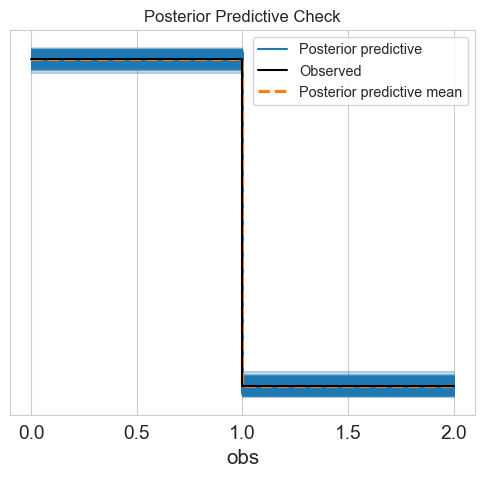

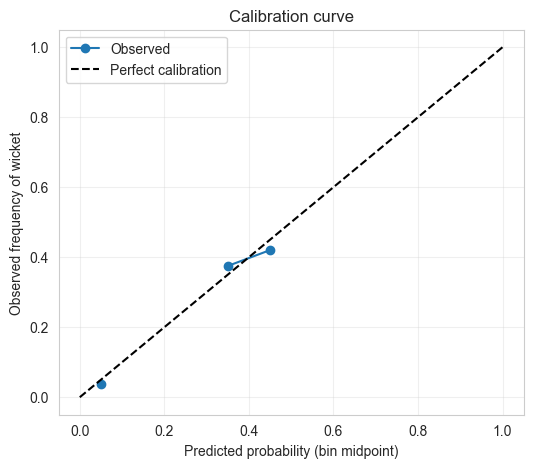

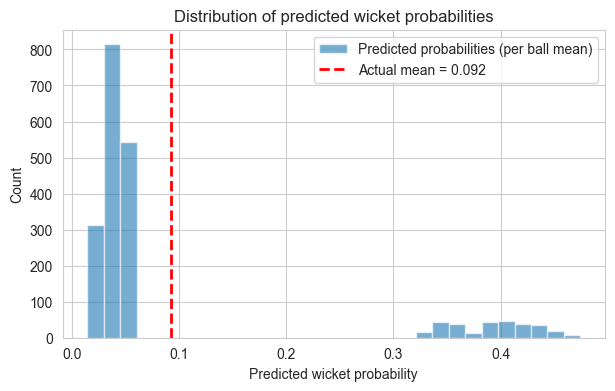

Brier score = 0.0673  (lower is better)


In [73]:
# Posterior Predictive Evaluation (PPC, calibration, distribution, Brier)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
#from sklearn.metrics import r2_score

#Set the df used for training (must be the same filter used for Phase 2)
df_model = df[df["is_death_over"] == 1].copy()   # <- same dataset used to train the model
y_true = df_model["Is_Wicket"].values

#Extract posterior-predictive samples robustly (works with different PyMC/ArviZ layouts)
# Try predictions group first (safer if you used predictions=True), otherwise fall back to posterior_predictive
try:
    y_pred_da = ppc.predictions["obs"]                # xarray DataArray (chain, draw, obs)
except Exception:
    y_pred_da = ppc.posterior_predictive["obs"]       # fallback

#Collapse chain+draw into a single sample dimension and compute mean prediction per observation
# This yields a 1D array of length = number of rows in df_model
y_pred_mean = y_pred_da.stack(sample=("chain", "draw")).mean("sample").values

# Sanity check: lengths must match
print("N (true) =", len(y_true), "N (pred) =", len(y_pred_mean))
assert len(y_true) == len(y_pred_mean), "Length mismatch — ensure df_model and PPC align"

#Posterior Predictive Check (visual)predicts wickets roughly as often as they actually happen
az.plot_ppc(ppc, figsize=(6,5))
plt.title("Posterior Predictive Check")
plt.show()

#Calibration check (binned) truth test
bins = np.linspace(0, 1, 11)
df_cal = pd.DataFrame({"pred": y_pred_mean, "actual": y_true})
df_cal["bin"] = pd.cut(df_cal["pred"], bins, include_lowest=True)
calibration = df_cal.groupby("bin",observed=False)["actual"].mean().reset_index()
# midpoint for plotting
calibration["midpoint"] = calibration["bin"].apply(lambda r: r.mid)

# Plot calibration curve
plt.figure(figsize=(6,5))
plt.plot(calibration["midpoint"], calibration["actual"], marker="o", label="Observed")
plt.plot([0,1], [0,1], linestyle="--", color="k", label="Perfect calibration")
plt.xlabel("Predicted probability (bin midpoint)")
plt.ylabel("Observed frequency of wicket")
plt.title("Calibration curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#Distribution comparison: histogram of per-ball predicted probabilities + actual mean
plt.figure(figsize=(7,4))
plt.hist(y_pred_mean, bins=30, alpha=0.6, label="Predicted probabilities (per ball mean)")
plt.axvline(y_true.mean(), color="r", linestyle="--", linewidth=2, label=f"Actual mean = {y_true.mean():.3f}")
plt.xlabel("Predicted wicket probability")
plt.ylabel("Count")
plt.title("Distribution of predicted wicket probabilities")
plt.legend()
plt.show()

#Brier score
brier = np.mean((y_true - y_pred_mean) ** 2)

print(f"Brier score = {brier:.4f}  (lower is better)")

In [74]:
import arviz as az

# 1. Summary (r_hat and ESS)
print(az.summary(trace, var_names=["alpha_b", "beta_pressure_b", "beta_batter", "beta_pitch"], round_to=3))

# 2. Check divergences
divergences = trace.sample_stats["diverging"].sum().item()
print("Divergences:", divergences)

# 3. r_hat overview-map - Did all 4 explorers draw the same map?
print("Max r_hat:", az.rhat(trace).to_array().max().item()) 

# 4. ESS overview-independent samples to trust(solid data to draw your conclusions)
print("Min ESS (ess_bulk):", az.ess(trace, method="bulk").to_array().min().item())

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_b[0]          -3.098  0.297  -3.649   -2.535      0.005    0.003   
alpha_b[1]          -3.098  0.295  -3.685   -2.573      0.005    0.003   
beta_pressure_b[0]   2.691  0.203   2.315    3.071      0.002    0.002   
beta_pressure_b[1]  -0.713  0.409  -1.487    0.043      0.004    0.005   
beta_batter         -0.059  0.086  -0.224    0.099      0.001    0.001   
beta_pitch[Batting] -0.209  0.283  -0.729    0.339      0.005    0.003   
beta_pitch[Bowling]  0.139  0.288  -0.431    0.659      0.005    0.003   
beta_pitch[Neutral]  0.024  0.284  -0.491    0.569      0.005    0.003   

                      ess_bulk  ess_tail  r_hat  
alpha_b[0]            3478.126  4588.267  1.001  
alpha_b[1]            3504.389  4543.939  1.001  
beta_pressure_b[0]    8780.014  7197.980  1.000  
beta_pressure_b[1]   10018.048  6631.043  1.001  
beta_batter           6987.849  5637.197  1.001  
beta_pitch[Batting]   3155.317  4

In [75]:
# Phase 3: Posterior, HDI, Delta, Plots

In [76]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# 1. Extract posterior samples for beta_pressure_b
bp = trace.posterior["beta_pressure_b"]

bowler_names = trace.posterior.coords["bowler"].values.tolist()
print("Bowler order in posterior:", bowler_names)

bp_samps = bp.stack(sample=("chain", "draw")).values.T

bp_B = bp_samps[:, 0] 
bp_A = bp_samps[:, 1] 

Bowler order in posterior: ['Bowler B', 'Bowler A']


In [78]:
# 2. Compute 94% HDI for each bowler
hdi_prob = 0.94
hdi_A = az.hdi(bp_A, hdi_prob=hdi_prob)
hdi_B = az.hdi(bp_B, hdi_prob=hdi_prob)

print(f"94% HDI (Bowler A): {hdi_A}")
print(f"94% HDI (Bowler B): {hdi_B}")

94% HDI (Bowler A): [-1.4873162   0.04322728]
94% HDI (Bowler B): [2.3145207  3.07095992]


In [79]:
# 3. Compute delta posterior and probability that B > A
delta = bp_B - bp_A

prob_B_gt_A = np.mean(delta > 0)
hdi_delta = az.hdi(delta, hdi_prob=hdi_prob)

print(f"P(Bowler B > Bowler A) = {prob_B_gt_A:.4f}")
print(f"94% HDI of delta (B - A): {hdi_delta}")

P(Bowler B > Bowler A) = 1.0000
94% HDI of delta (B - A): [2.60202635 4.25421298]


In [80]:
# 4. Calculate medians / means for reporting
median_A = np.median(bp_A)
median_B = np.median(bp_B)
median_delta = np.median(delta)

print(f"Median beta_pressure_b — Bowler A: {median_A:.3f}, Bowler B: {median_B:.3f}")
print(f"Median delta (B - A): {median_delta:.3f}")

Median beta_pressure_b — Bowler A: -0.691, Bowler B: 2.689
Median delta (B - A): 3.397


In [81]:
# 5. Convert log-odds effect to probability change
alpha_b = trace.posterior["alpha_b"].stack(sample=("chain","draw")).values.T
alpha_B = alpha_b[:, 0]  
alpha_A = alpha_b[:, 1] 

beta_pitch = trace.posterior["beta_pitch"].stack(sample=("chain","draw")).values.T

pitch_idx_rep = 0# Likely 'Batting' pitch
pitch_term = beta_pitch[:, pitch_idx_rep]

# compute sample-wise probability changes - sigmoid
pA_no = 1 / (1 + np.exp(-(alpha_A + pitch_term)))
pA_yes = 1 / (1 + np.exp(-(alpha_A + pitch_term + bp_A)))
pB_no = 1 / (1 + np.exp(-(alpha_B + pitch_term)))
pB_yes = 1 / (1 + np.exp(-(alpha_B + pitch_term + bp_B)))

prob_change_A = np.median(pA_yes - pA_no)
prob_change_B = np.median(pB_yes - pB_no)

print(f"Representative median increase in wicket probability after pressure:")
print(f"Bowler A = {prob_change_A:.4f}, Bowler B = {prob_change_B:.4f}")


Representative median increase in wicket probability after pressure:
Bowler A = -0.0171, Bowler B = 0.3147


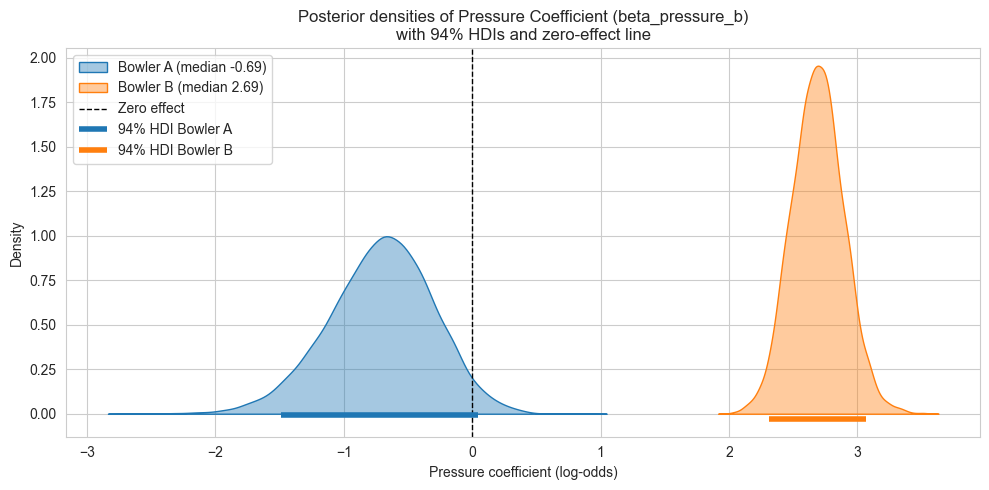

In [82]:
# 6. Plotting: overlay densities + HDI + zero line
plt.figure(figsize=(10,5))
sns.kdeplot(bp_A, fill=True, alpha=0.4, label=f"Bowler A (median {median_A:.2f})")
sns.kdeplot(bp_B, fill=True, alpha=0.4, label=f"Bowler B (median {median_B:.2f})")

plt.axvline(0, color="k", linestyle="--", linewidth=1, label="Zero effect")

plt.hlines(y=-0.01, xmin=hdi_A[0], xmax=hdi_A[1], colors='C0', linewidth=4, label="94% HDI Bowler A")
plt.hlines(y=-0.03, xmin=hdi_B[0], xmax=hdi_B[1], colors='C1', linewidth=4, label="94% HDI Bowler B")

plt.title("Posterior densities of Pressure Coefficient (beta_pressure_b)\nwith 94% HDIs and zero-effect line")
plt.xlabel("Pressure coefficient (log-odds)")
plt.legend()
plt.tight_layout()
plt.show()

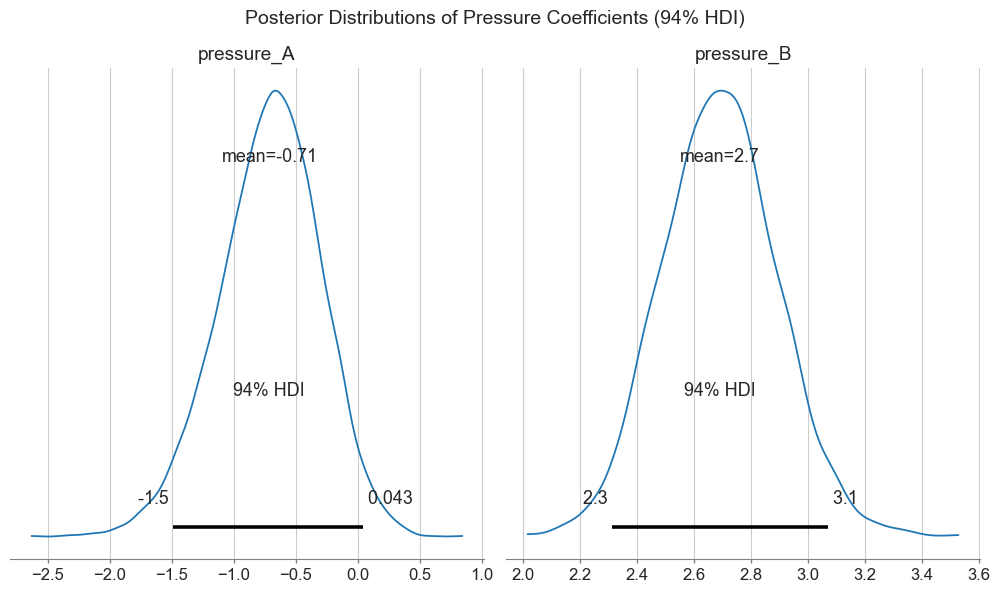

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)



=== 94% HDI Summary for Pressure Coefficients ===
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
pressure_A -0.713  0.409  -1.487    0.043      0.004    0.005  9972.552   
pressure_B  2.691  0.203   2.315    3.071      0.002    0.002  8700.545   

            ess_tail  r_hat  
pressure_A  6568.382    NaN  
pressure_B  7137.437    NaN  


In [98]:
#Posterior Visualization + Summary

# Convert samples into a dict format ArviZ accepts
posterior_dict = {
    "pressure_A": bp_A,
    "pressure_B": bp_B
}

# 1. ArviZ Posterior Plot (Automatic KDE + HDI)
az.plot_posterior(
    posterior_dict,
    hdi_prob=0.94,
    figsize=(10, 6),
    textsize=12,
)
plt.suptitle("Posterior Distributions of Pressure Coefficients (94% HDI)", fontsize=14)
plt.tight_layout()
plt.show()

# 2. ArviZ Summary Table (mean, sd, HDI, ESS, R-hat)
summary = az.summary(
    posterior_dict,
    hdi_prob=0.94,
    round_to=3
)
print("\n=== 94% HDI Summary for Pressure Coefficients ===")
print(summary)

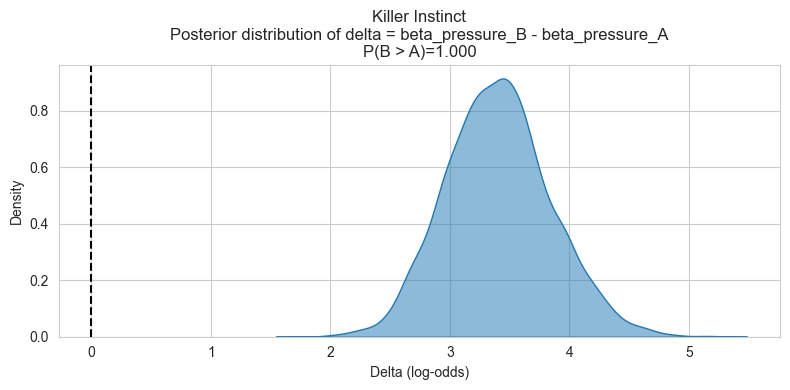

In [84]:
# 7. Plot delta distribution
plt.figure(figsize=(8,4))
sns.kdeplot(delta, fill=True, alpha=0.5)
plt.axvline(0, color="k", linestyle="--")

plt.title(f"Killer Instinct\nPosterior distribution of delta = beta_pressure_B - beta_pressure_A\nP(B > A)={prob_B_gt_A:.3f}")
plt.xlabel("Delta (log-odds)")
plt.tight_layout()
plt.show()